# The Unitary Events Analysis

The executed version of this tutorial is at https://elephant.readthedocs.io/en/latest/tutorials/unitary_event_analysis.html

The Unitary Events (UE) analysis \[1\] tool allows us to  reliably detect correlated spiking activity that is not explained by the firing rates of the neurons alone. It was designed to detect coordinated spiking activity that occurs significantly more often than predicted by the firing rates of the neurons. The method allows one to analyze correlations not only between pairs of neurons but also between multiple neurons, by considering the various spike patterns across the neurons. In addition, the method allows one to extract the dynamics of correlation between the neurons by perform-ing the analysis in a time-resolved manner. This enables us to relate the occurrence of spike synchrony to behavior.

The algorithm:

1. Align trials, decide on width of analysis window.
2. Decide on allowed coincidence width.
3. Perform a sliding window analysis. In each window:
    1. Detect and count coincidences.
    2. Calculate expected number of coincidences.
    3. Evaluate significance of detected coincidences.
    4. If significant, the window contains Unitary Events.
4. Explore behavioral relevance of UE epochs.

References:

1. Grün, S., Diesmann, M., Grammont, F., Riehle, A., & Aertsen, A. (1999). Detecting unitary events without discretization of time. Journal of neuroscience methods, 94(1), 67-79.

In [1]:
import random
import string
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
import neo

import elephant.unitary_event_analysis as ue

# Fix random seed to guarantee fixed output
random.seed(1224)

Next, we download a data file containing spike train data from multiple trials of two neurons.

In [2]:
# Download trial data
!curl https://gin.g-node.org/INM-6/elephant-data/raw/7c361d8143d605bf2e31a883189b0b7a92b58f2a/tutorials/tutorial_unitary_event_analysis/data/dataset-1.nix --output dataset-1.nix --location

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1723k    0 1723k    0     0   427k      0 --:--:--  0:00:04 --:--:--  427k


# Write a plotting function

In [3]:
# borrowed from Viziphant

plot_params_default = {
    # epochs to be marked on the time axis
    'events': {},
    # figure size
    'figsize': (10, 12),
    # right margin
    'right': 0.9,
    # top margin
    'top': 0.9,
    # bottom margin
    'bottom': 0.1,
    # left margin
    'left': 0.1,
    # horizontal white space between subplots
    'hspace': 0.5,
    # width white space between subplots
    'wspace': 0.5,
    # font size
    'fsize': 12,
    # the actual unit ids from the experimental recording
    'unit_real_ids': None,
    # line width
    'lw': 2,
    # marker size for the UEs and coincidences
    'ms': 5,
    # figure title
    'suptitle': None,
}


def plot_ue(spiketrains, Js_dict, significance_level=0.05,
            **plot_params):
    """
    Plots the results of pairwise unitary event analysis as a column of six
    subplots, comprised of raster plot, peri-stimulus time histogram,
    coincident event plot, coincidence rate plot, significance plot and
    unitary event plot, respectively.

    Parameters
    ----------
    spiketrains : list of list of neo.SpikeTrain
        A nested list of trials, neurons and their neo.SpikeTrain objects,
        respectively. This should be identical to the one used to generate
        Js_dict.
    Js_dict : dict
        The output of
        :func:`elephant.unitary_event_analysis.jointJ_window_analysis`
        function. The values of each key has the shape of:

          * different window --> 0-axis.
          * different pattern hash --> 1-axis;

        Dictionary keys:

        'Js': list of float
          JointSurprise of different given patterns within each window.
        'indices': list of list of int
          A list of indices of pattern within each window.
        'n_emp': list of int
          The empirical number of each observed pattern.
        'n_exp': list of float
          The expected number of each pattern.
        'rate_avg': list of float
          The average firing rate of each neuron.

    significance_level : float
        The significance threshold used to determine which coincident events
        are classified as unitary events within a window.
    **plot_params
        User-defined plotting parameters used to update the default plotting
        parameter values. The valid keys:

        'events' : list
          Epochs to be marked on the time axis.
        'figsize' : tuple of int
          The dimensions for the figure size.
        'right' : float
          The size of the right margin.
        'top' : float
          The size of the top margin.
        'bottom' : float
          The size of the bottom margin.
        'left' : float
          The size of the left margin.
        'hspace' : flaot
          The size of the horizontal white space between subplots.
        'wspace' : float
          The width of the white space between subplots.
        'fsize' : int
          The size of the font.
        'unit_real_ids' : list of int
          The unit ids from the experimental recording.
        'lw' : int
          The default line width.
        'ms' : int
          The marker size for the unitary events and coincidences.

    Returns
    -------
    result : FigureUE
        The container for Axes objects generated by the function. Individual
        axes can be accessed using the following identifiers:

        * axes_spike_events : matplotlib.axes.Axes

          Contains the elements of the spike events subplot.
        * axes_spike_rates : matplotlib.axes.Axes

          Contains the elements of the spike rates subplot.
        * axes_coincident_events : matplotlib.axes.Axes

          Contains the elements of the coincident events subplot.
        * axes_coincidence_rates : matplotlib.axes.Axes

          Contains the elements of the coincidence rates subplot.
        * axes_significance : matplotlib.axes.Axes

          Contains the elements of the statistical significance subplot.
        * axes_unitary_events : matplotlib.axes.Axes

          Contains the elements of the unitary events subplot.

    Examples
    --------
    Unitary Events of homogenous Poisson random processes.

    Since we don't expect to find significant correlations in random processes,
    we show non-significant events (``significance_level=0.34``). Typically,
    in your analyses, the significant level threshold is ~0.05.

    .. plot::
        :include-source:

        import matplotlib.pyplot as plt
        import numpy as np
        import quantities as pq

        import viziphant
        from elephant.spike_train_generation import homogeneous_poisson_process
        from elephant.unitary_event_analysis import jointJ_window_analysis

        np.random.seed(10)

        spiketrains1 = [homogeneous_poisson_process(rate=20 * pq.Hz,
                        t_stop=2 * pq.s) for _ in range(5)]
        spiketrains2 = [homogeneous_poisson_process(rate=50 * pq.Hz,
                        t_stop=2 * pq.s) for _ in range(5)]

        spiketrains = np.stack((spiketrains1, spiketrains2), axis=1)
        ue_dict = jointJ_window_analysis(spiketrains,
                                         bin_size=5 * pq.ms,
                                         win_size=100 * pq.ms,
                                         win_step=10 * pq.ms)
        viziphant.unitary_event_analysis.plot_ue(spiketrains, Js_dict=ue_dict,
                                                 significance_level=0.34,
                                                 unit_real_ids=['1', '2'])
        plt.show()

    Refer to `UEA Tutorial <https://elephant.readthedocs.io/en/latest/
    tutorials/unitary_event_analysis.html>`_ for real-case scenario.
    """
    n_trials = len(spiketrains)
    n_neurons = len(spiketrains[0])

    input_parameters = Js_dict['input_parameters']
    t_start = input_parameters['t_start']
    t_stop = input_parameters['t_stop']
    bin_size = input_parameters['bin_size']
    win_size = input_parameters['win_size']
    win_step = input_parameters['win_step']
    pattern_hash = input_parameters['pattern_hash']
    if len(pattern_hash) > 1:
        raise ValueError(f"To not clutter the plots, only one pattern hash is "
                         f"required; got {pattern_hash}. You can call this "
                         f"function multiple times for each hash at a time.")
    for key in ['Js', 'n_emp', 'n_exp', 'rate_avg']:
        Js_dict[key] = Js_dict[key].squeeze()
    neurons_participated = ue.inverse_hash_from_pattern(pattern_hash,
                                                        N=n_neurons).squeeze()

    t_winpos = ue._winpos(t_start=t_start, t_stop=t_stop, win_size=win_size,
                          win_step=win_step)
    Js_sig = ue.jointJ(significance_level)

    # figure format
    plot_params_user = plot_params
    plot_params = plot_params_default.copy()
    plot_params.update(plot_params_user)
    if plot_params['unit_real_ids'] is None:
        plot_params['unit_real_ids'] = ['not specified'] * n_neurons
    if len(plot_params['unit_real_ids']) != n_neurons:
        raise ValueError('length of unit_ids should be' +
                         'equal to number of neurons!')
    plt.rcParams.update({'font.size': plot_params['fsize']})
    ls = '-'
    alpha = 0.5

    fig, axes = plt.subplots(nrows=6, sharex=True,
                             figsize=plot_params['figsize'])
    axes[5].get_shared_y_axes().join(axes[0], axes[2], axes[5])

    for ax in (axes[0], axes[2], axes[5]):
        for n in range(n_neurons):
            for tr, data_tr in enumerate(spiketrains):
                ax.plot(data_tr[n].rescale('ms').magnitude,
                        np.full_like(data_tr[n].magnitude,
                                     fill_value=n * n_trials + tr),
                        '.', markersize=0.5, color='k')
        for n in range(1, n_neurons):
            # subtract 0.5 to separate the raster plots;
            # otherwise, the line crosses the raster spikes
            ax.axhline(n * n_trials - 0.5, lw=0.5, color='k')
        ymax = max(ax.get_ylim()[1], 2 * n_trials - 0.5)
        ax.set_ylim([-0.5, ymax])
        ax.set_yticks([n_trials - 0.5, 2 * n_trials - 0.5])
        ax.set_yticklabels([1, n_trials], fontsize=plot_params['fsize'])
        ax.set_ylabel('Trial', fontsize=plot_params['fsize'])

    for i, ax in enumerate(axes):
        ax.set_xlim([t_winpos[0], t_winpos[-1] + win_size])
        ax.text(-0.05, 1.1, string.ascii_uppercase[i],
                transform=ax.transAxes, size=plot_params['fsize'] + 5,
                weight='bold')
        for key in plot_params['events'].keys():
            for event_time in plot_params['events'][key]:
                ax.axvline(event_time, ls=ls, color='r', lw=plot_params['lw'],
                           alpha=alpha)

    axes[0].set_title('Spike Events')
    axes[0].text(1.0, 1.0, f"Unit {plot_params['unit_real_ids'][-1]}",
                 fontsize=plot_params['fsize'] // 2,
                 horizontalalignment='right',
                 verticalalignment='bottom',
                 transform=axes[0].transAxes)
    axes[0].text(1.0, 0, f"Unit {plot_params['unit_real_ids'][0]}",
                 fontsize=plot_params['fsize'] // 2,
                 horizontalalignment='right',
                 verticalalignment='top',
                 transform=axes[0].transAxes)

    axes[1].set_title('Spike Rates')
    for n in range(n_neurons):
        axes[1].plot(t_winpos + win_size / 2.,
                     Js_dict['rate_avg'][:, n].rescale('Hz'),
                     label=f"Unit {plot_params['unit_real_ids'][n]}",
                     lw=plot_params['lw'])
    axes[1].set_ylabel('Hz', fontsize=plot_params['fsize'])
    axes[1].legend(fontsize=plot_params['fsize'] // 2, loc='upper right')
    axes[1].locator_params(axis='y', tight=True, nbins=3)

    axes[2].set_title('Coincident Events')
    for n in range(n_neurons):
        if not neurons_participated[n]:
            continue
        for tr, data_tr in enumerate(spiketrains):
            indices = np.unique(Js_dict['indices'][f'trial{tr}'])
            axes[2].plot(indices * bin_size,
                         np.full_like(indices, fill_value=n * n_trials + tr),
                         ls='', ms=plot_params['ms'], marker='s',
                         markerfacecolor='none',
                         markeredgecolor='c')
    axes[2].set_ylabel('Trial', fontsize=plot_params['fsize'])

    axes[3].set_title('Coincidence Rates')
    axes[3].plot(t_winpos + win_size / 2.,
                 Js_dict['n_emp'] / (
                             win_size.rescale('s').magnitude * n_trials),
                 label='Empirical', lw=plot_params['lw'], color='c')
    axes[3].plot(t_winpos + win_size / 2.,
                 Js_dict['n_exp'] / (
                             win_size.rescale('s').magnitude * n_trials),
                 label='Expected', lw=plot_params['lw'], color='m')
    axes[3].set_ylabel('Hz', fontsize=plot_params['fsize'])
    axes[3].legend(fontsize=plot_params['fsize'] // 2, loc='upper right')
    axes[3].locator_params(axis='y', tight=True, nbins=3)

    axes[4].set_title('Statistical Significance')
    axes[4].plot(t_winpos + win_size / 2., Js_dict['Js'], lw=plot_params['lw'],
                 color='k')
    axes[4].axhline(Js_sig, ls='-', color='r')
    axes[4].axhline(-Js_sig, ls='-', color='g')
    xlim_ax4 = axes[4].get_xlim()[1]
    alpha_pos_text = axes[4].text(xlim_ax4, Js_sig, r'$\alpha +$', color='r',
                                  horizontalalignment='right',
                                  verticalalignment='bottom')
    alpha_neg_text = axes[4].text(xlim_ax4, -Js_sig, r'$\alpha -$', color='g',
                                  horizontalalignment='right',
                                  verticalalignment='top')
    axes[4].set_yticks([ue.jointJ(1 - significance_level), ue.jointJ(0.5),
                        ue.jointJ(significance_level)])
    # Try '1 - 0.34' to see the floating point errors
    axes[4].set_yticklabels(np.round([1 - significance_level, 0.5,
                                      significance_level], decimals=6))

    # autoscale fix to mind the text positions.
    # See https://stackoverflow.com/questions/11545062/
    # matplotlib-autoscale-axes-to-include-annotations
    plt.get_current_fig_manager().canvas.draw()
    for text_handle in (alpha_pos_text, alpha_neg_text):
        bbox = text_handle.get_window_extent()
        bbox_data = bbox.transformed(axes[4].transData.inverted())
        axes[4].update_datalim(bbox_data.corners(), updatex=False)
    axes[4].autoscale_view()

    mask_nonnan = ~np.isnan(Js_dict['Js'])
    significant_win_idx = np.nonzero(Js_dict['Js'][mask_nonnan] >= Js_sig)[0]
    t_winpos_significant = t_winpos[mask_nonnan][significant_win_idx]
    axes[5].set_title('Unitary Events')
    if len(t_winpos_significant) > 0:
        for n in range(n_neurons):
            if not neurons_participated[n]:
                continue
            for tr, data_tr in enumerate(spiketrains):
                indices = np.unique(Js_dict['indices'][f'trial{tr}'])
                indices_significant = []
                for t_sig in t_winpos_significant:
                    mask = (indices * bin_size >= t_sig
                            ) & (indices * bin_size < t_sig + win_size)
                    indices_significant.append(indices[mask])
                indices_significant = np.hstack(indices_significant)
                indices_significant = np.unique(indices_significant)
                # does nothing if indices_significant is empty
                axes[5].plot(indices_significant * bin_size,
                             np.full_like(indices_significant,
                                          fill_value=n * n_trials + tr),
                             ms=plot_params['ms'], marker='s', ls='',
                             mfc='none', mec='r')
    axes[5].set_xlabel(f'Time ({t_winpos.dimensionality})',
                       fontsize=plot_params['fsize'])
    for key in plot_params['events'].keys():
        for event_time in plot_params['events'][key]:
            axes[5].text(event_time - 10 * pq.ms,
                         axes[5].get_ylim()[0] - 35, key,
                         fontsize=plot_params['fsize'], color='r')

    plt.suptitle(plot_params['suptitle'], fontsize=20)
    plt.subplots_adjust(top=plot_params['top'],
                        right=plot_params['right'],
                        left=plot_params['left'],
                        bottom=plot_params['bottom'],
                        hspace=plot_params['hspace'],
                        wspace=plot_params['wspace'])
    
    return axes

# Load data and extract spiketrains

In [4]:
io = neo.io.NixIO("./dataset-1.nix",'ro')
block = io.read_block()

spiketrains = []
# each segment contains a single trial
for ind in range(len(block.segments)):
    spiketrains.append (block.segments[ind].spiketrains)

# Calculate Unitary Events

/home/kern/miniconda3/envs/elephant_nixio/lib/python3.9/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


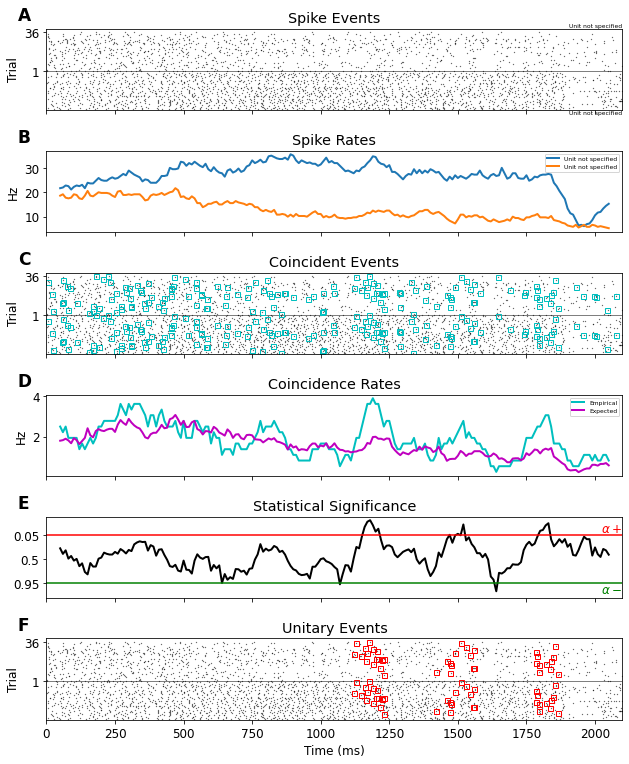

In [5]:
UE = ue.jointJ_window_analysis(
    spiketrains, bin_size=5*pq.ms, winsize=100*pq.ms, winstep=10*pq.ms, pattern_hash=[3])

plot_ue(spiketrains, UE, significance_level=0.05)
plt.show()